# Learning Discrete-Time Estimation and Control with Transformers: Baselines

In [11]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 250 # how long to simulate the trajectory
CUT = 5 # cutoff the first 5 elements of the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = 2
# NUM_TRAJ = 100 # number of trajectories to simulate

import time

# State Estimation: Continuous State Space 

## Generate Trajectories that follow a fixed path on the unit circle

In [12]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(T, input_dim))*2 - 1)

In [13]:
traj = np.zeros(shape=(T, state_dim))
meas = np.zeros(shape=(T, obs_dim))
pure_poses = np.zeros(shape=(T, obs_dim))
x = x0
pure_pos = x0
pos_no_inputs = x0

for i in range(T):
    u_t = u_seq[i]
    w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
    x = A @ x + w_t + B @ u_t # inputs
    v_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=R) # sensor noise
    pure_pos = A @ pure_pos + B @ u_t # original pose, without any process noise or sensor noise
    y = C @ x + v_t
    traj[i] = x
    meas[i] = y
    pure_poses[i] = pure_pos

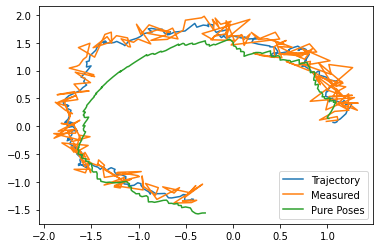

In [14]:
# plot trajectory and noisy measurements

plt.figure()
#fig, ax = plt.subplots()
linetraj = plt.plot(traj[CUT:,0], traj[CUT:,1], label='Trajectory')
linemeas = plt.plot(meas[CUT:,0], meas[CUT:,1], label='Measured')
linepure = plt.plot(pure_poses[CUT:,0], pure_poses[CUT:,1], label='Pure Poses')
plt.legend()
plt.show()

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

Converged in 18 iterations


<Figure size 432x288 with 0 Axes>

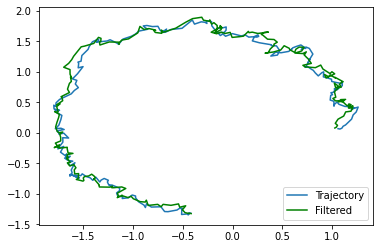

Sum of Squared Error 1.0950074377950418


In [15]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
fltr = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linefltr, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr = np.linalg.norm(fltr[CUT:,:] - traj[CUT:,:])
print("Sum of Squared Error", err_fltr)

### 1b. Kalman Filter with pure steady state gains

Converged in 0 iterations


<Figure size 432x288 with 0 Axes>

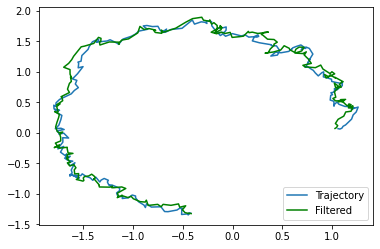

Sum of Squared Error 1.0938051955341144


In [16]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
kinematics_forward.run_till_ss()
fltr_ss = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(fltr_ss[CUT:,0], fltr_ss[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr_ss = np.linalg.norm(fltr_ss[CUT:,:] - traj[CUT:,:])
print("Sum of Squared Error", err_fltr_ss)

## 2. Least Squares System ID + Kalman Filtering

###  2a.i. Update on the identified system at each timestep

In [17]:
# Use the same data as before, but now no peeking on what are the actual A, B matrices
A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
id_fltr = np.zeros(shape=(T,state_dim))
for t in range(T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    
    kinematics.A = A_found
    kinematics.B = B_found
    kinematics.predict(u_seq[t])
    kinematics.update(meas[t])
    id_fltr[t] = kinematics.state

<Figure size 432x288 with 0 Axes>

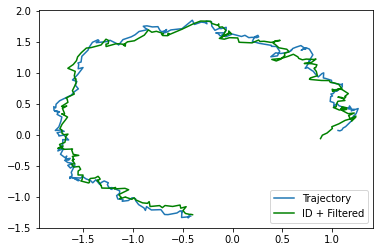

Sum of Squared Error 2.015648856207504


In [18]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(id_fltr[CUT:,0], id_fltr[CUT:,1], label="ID + Filtered", color='g')
plt.legend()
plt.show()

err_id_fltr = np.linalg.norm(id_fltr[CUT:,:] - traj[CUT:,:])
print("Sum of Squared Error", err_id_fltr)

# 2a.ii. Kalman filter for each timestep simulated from the start

In [19]:
id_fltr_sim = np.zeros(shape=(T,state_dim))
for t in range(1, T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    kinematics = KFilter(A_found, B_found, C, Q, R, x0)
    id_fltr_sim[t] = kinematics.simulate(meas[:t], u_seq[:t])[-1]

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

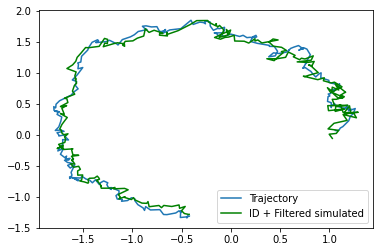

Sum of Squared Error 2.171687928212451


In [20]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory") # cut out first point since it starts at the origin
#linemeas, = ax.plot(meas[CUT:,0], meas[CUT:,1], label="Measured")
linefltr, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated", color='g')
plt.legend()
plt.show()

err_fltr_sim = np.linalg.norm(id_fltr_sim[CUT:, :] - traj[CUT:, :])
print("Sum of Squared Error", err_fltr_sim)

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 
(Just use the identity for now, later can try to learn C' as well)

In [23]:
kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
kinematics.fit(meas, u_seq, eps=2.5, maxIt=float('inf'))
learned_kf_sim = kinematics.simulate(meas, u_seq)

Iteration 10 : Loss 22.550729332778936
Iteration 20 : Loss 29.44925419184809
Iteration 30 : Loss 13.48050166678249
Iteration 40 : Loss 10.707246080682083
Iteration 50 : Loss 9.49294154602064
Iteration 60 : Loss 9.221431673934934
Iteration 70 : Loss 8.924047283382569
Iteration 80 : Loss 8.8577986039417
Iteration 90 : Loss 8.786762720010929
Iteration 100 : Loss 8.720458133865446
Iteration 110 : Loss 8.65960453643061
Iteration 120 : Loss 8.598389850247374
Iteration 130 : Loss 8.537058205897354
Iteration 140 : Loss 8.474948229182576
Iteration 150 : Loss 8.412220920573972
Iteration 160 : Loss 8.349163303296976
Iteration 170 : Loss 8.28585854283256
Iteration 180 : Loss 8.222478696713859
Iteration 190 : Loss 8.159160067159593
Iteration 200 : Loss 8.09602800053401
Iteration 210 : Loss 8.033194416302981
Iteration 220 : Loss 7.970758472866687
Iteration 230 : Loss 7.908807242771563
Iteration 240 : Loss 7.847416915197473
Iteration 250 : Loss 7.7866536088555245
Iteration 260 : Loss 7.72657431803641

Iteration 2090 : Loss 4.265833899005954
Iteration 2100 : Loss 4.261310050571646
Iteration 2110 : Loss 4.25683084730963
Iteration 2120 : Loss 4.2523957303595585
Iteration 2130 : Loss 4.248004149091082
Iteration 2140 : Loss 4.243655560944393
Iteration 2150 : Loss 4.239349431274428
Iteration 2160 : Loss 4.235085233198849
Iteration 2170 : Loss 4.23086244744955
Iteration 2180 : Loss 4.22668056222771
Iteration 2190 : Loss 4.22253907306221
Iteration 2200 : Loss 4.218437482671391
Iteration 2210 : Loss 4.214375300828044
Iteration 2220 : Loss 4.210352044227481
Iteration 2230 : Loss 4.206367236358787
Iteration 2240 : Loss 4.2024204073789315
Iteration 2250 : Loss 4.198511093989857
Iteration 2260 : Loss 4.194638839318393
Iteration 2270 : Loss 4.190803192798911
Iteration 2280 : Loss 4.187003710058682
Iteration 2290 : Loss 4.183239952805827
Iteration 2300 : Loss 4.179511488719883
Iteration 2310 : Loss 4.175817891344798
Iteration 2320 : Loss 4.172158739984347
Iteration 2330 : Loss 4.168533619600002
It

Iteration 4130 : Loss 3.8174991565073015
Iteration 4140 : Loss 3.8163762856913475
Iteration 4150 : Loss 3.8152572878439304
Iteration 4160 : Loss 3.814142122364233
Iteration 4170 : Loss 3.813030749333278
Iteration 4180 : Loss 3.8119231295066505
Iteration 4190 : Loss 3.8108192243072203
Iteration 4200 : Loss 3.8097189958179425
Iteration 4210 : Loss 3.8086224067746195
Iteration 4220 : Loss 3.807529420558757
Iteration 4230 : Loss 3.806440001190362
Iteration 4240 : Loss 3.8053541133208686
Iteration 4250 : Loss 3.8042717222260047
Iteration 4260 : Loss 3.8031927937987176
Iteration 4270 : Loss 3.8021172945421395
Iteration 4280 : Loss 3.801045191562561
Iteration 4290 : Loss 3.7999764525624253
Iteration 4300 : Loss 3.798911045833366
Iteration 4310 : Loss 3.797848940249276
Iteration 4320 : Loss 3.796790105259375
Iteration 4330 : Loss 3.795734510881329
Iteration 4340 : Loss 3.7946821276943887
Iteration 4350 : Loss 3.7936329268325695
Iteration 4360 : Loss 3.7925868799778377
Iteration 4370 : Loss 3.7

Iteration 6160 : Loss 3.6430445582974667
Iteration 6170 : Loss 3.642404075654817
Iteration 6180 : Loss 3.6417656156866767
Iteration 6190 : Loss 3.641129177320628
Iteration 6200 : Loss 3.640494759459645
Iteration 6210 : Loss 3.639862360981938
Iteration 6220 : Loss 3.639231980740746
Iteration 6230 : Loss 3.638603617564193
Iteration 6240 : Loss 3.6379772702551487
Iteration 6250 : Loss 3.6373529375910376
Iteration 6260 : Loss 3.6367306183237624
Iteration 6270 : Loss 3.636110311179539
Iteration 6280 : Loss 3.635492014858792
Iteration 6290 : Loss 3.63487572803606
Iteration 6300 : Loss 3.634261449359892
Iteration 6310 : Loss 3.6336491774527286
Iteration 6320 : Loss 3.6330389109108783
Iteration 6330 : Loss 3.6324306483044007
Iteration 6340 : Loss 3.6318243881770416
Iteration 6350 : Loss 3.6312201290462007
Iteration 6360 : Loss 3.630617869402854
Iteration 6370 : Loss 3.630017607711536
Iteration 6380 : Loss 3.629419342410268
Iteration 6390 : Loss 3.6288230719105616
Iteration 6400 : Loss 3.628228

Iteration 8190 : Loss 3.5513442443888055
Iteration 8200 : Loss 3.5510601355838807
Iteration 8210 : Loss 3.5507773907558002
Iteration 8220 : Loss 3.5504960054055714
Iteration 8230 : Loss 3.550215975033671
Iteration 8240 : Loss 3.5499372951402317
Iteration 8250 : Loss 3.5496599612252244
Iteration 8260 : Loss 3.549383968788637
Iteration 8270 : Loss 3.549109313330689
Iteration 8280 : Loss 3.5488359903519755
Iteration 8290 : Loss 3.5485639953537005
Iteration 8300 : Loss 3.5482933238378207
Iteration 8310 : Loss 3.5480239713072663
Iteration 8320 : Loss 3.5477559332660924
Iteration 8330 : Loss 3.5474892052196982
Iteration 8340 : Loss 3.5472237826749824
Iteration 8350 : Loss 3.546959661140551
Iteration 8360 : Loss 3.546696836126885
Iteration 8370 : Loss 3.546435303146527
Iteration 8380 : Loss 3.5461750577142848
Iteration 8390 : Loss 3.5459160953473803
Iteration 8400 : Loss 3.5456584115656558
Iteration 8410 : Loss 3.5454020018917576
Iteration 8420 : Loss 3.5451468618513
Iteration 8430 : Loss 3.5

Iteration 10210 : Loss 3.5159512413286427
Iteration 10220 : Loss 3.515860843962018
Iteration 10230 : Loss 3.5157710743642987
Iteration 10240 : Loss 3.515681930047434
Iteration 10250 : Loss 3.5155934085303944
Iteration 10260 : Loss 3.515505507338994
Iteration 10270 : Loss 3.5154182240057548
Iteration 10280 : Loss 3.5153315560697664
Iteration 10290 : Loss 3.5152455010765626
Iteration 10300 : Loss 3.5151600565779555
Iteration 10310 : Loss 3.5150752201319078
Iteration 10320 : Loss 3.5149909893023956
Iteration 10330 : Loss 3.51490736165927
Iteration 10340 : Loss 3.514824334778102
Iteration 10350 : Loss 3.5147419062400704
Iteration 10360 : Loss 3.5146600736318114
Iteration 10370 : Loss 3.5145788345452686
Iteration 10380 : Loss 3.514498186577581
Iteration 10390 : Loss 3.5144181273309427
Iteration 10400 : Loss 3.514338654412439
Iteration 10410 : Loss 3.5142597654339633
Iteration 10420 : Loss 3.51418145801204
Iteration 10430 : Loss 3.514103729767725
Iteration 10440 : Loss 3.51402657832645
Itera

Iteration 12190 : Loss 3.507313870160632
Iteration 12200 : Loss 3.507302536900607
Iteration 12210 : Loss 3.5072913824685945
Iteration 12220 : Loss 3.5072804049047144
Iteration 12230 : Loss 3.5072696022575505
Iteration 12240 : Loss 3.507258972584276
Iteration 12250 : Loss 3.507248513950763
Iteration 12260 : Loss 3.507238224431678
Iteration 12270 : Loss 3.5072281021105955
Iteration 12280 : Loss 3.5072181450800946
Iteration 12290 : Loss 3.5072083514418875
Iteration 12300 : Loss 3.5071987193068943
Iteration 12310 : Loss 3.5071892467953556
Iteration 12320 : Loss 3.507179932036952
Iteration 12330 : Loss 3.5071707731708797
Iteration 12340 : Loss 3.5071617683459584
Iteration 12350 : Loss 3.507152915720749
Iteration 12360 : Loss 3.50714421346363
Iteration 12370 : Loss 3.5071356597528984
Iteration 12380 : Loss 3.5071272527768858
Iteration 12390 : Loss 3.5071189907340203
Iteration 12400 : Loss 3.5071108718329542
Iteration 12410 : Loss 3.507102894292635
Iteration 12420 : Loss 3.507095056342409
Ite

Iteration 14170 : Loss 3.506742496461507
Iteration 14180 : Loss 3.5067424457599277
Iteration 14190 : Loss 3.5067423962630357
Iteration 14200 : Loss 3.506742349405262
Iteration 14210 : Loss 3.5067423045004382
Iteration 14220 : Loss 3.5067422616106865
Iteration 14230 : Loss 3.5067422205650143
Iteration 14240 : Loss 3.5067421813168838
Iteration 14250 : Loss 3.506742143783028
Iteration 14260 : Loss 3.506742107894062
Iteration 14270 : Loss 3.506742073584312
Iteration 14280 : Loss 3.5067420407898893
Iteration 14290 : Loss 3.506742009449567
Iteration 14300 : Loss 3.5067419795045596
Iteration 14310 : Loss 3.5067419508983453
Iteration 14320 : Loss 3.5067419235765342
Iteration 14330 : Loss 3.5067418974867635
Iteration 14340 : Loss 3.5067418725786346
Iteration 14350 : Loss 3.506741848803617
Iteration 14360 : Loss 3.5067418261149697
Iteration 14370 : Loss 3.5067418044676892
Iteration 14380 : Loss 3.506741783818445
Iteration 14390 : Loss 3.5067417641255085
Iteration 14400 : Loss 3.506741745348708
I

KeyboardInterrupt: 

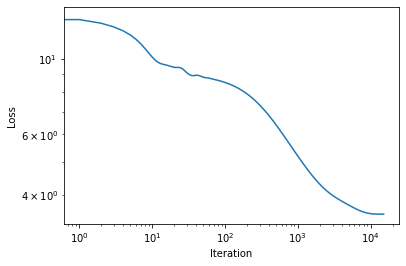

In [24]:
plt.figure()
plt.plot(kinematics.losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

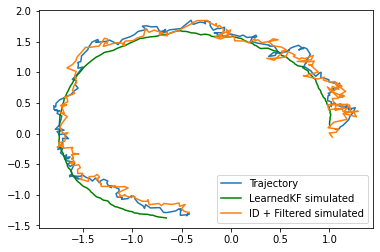

In [25]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='g')
lineopt, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated")
plt.legend()
plt.show()



In [26]:
print("Aprime", kinematics.Aprime)
print("Aprime true", A @ (np.eye(state_dim) - kinematics_forward.K @ C))
print("Bprime", kinematics.Bprime)
print("Bprime true", B)
print("Gprime", kinematics.Gprime)
print("Gprime true", A @ kinematics_forward.K)

Aprime tensor([[ 0.7611, -0.0112],
        [-0.0218,  0.7525]], requires_grad=True)
Aprime true [[ 0.7297356  -0.01273758]
 [ 0.01273758  0.7297356 ]]
Bprime tensor([[0.5052],
        [0.4651]], requires_grad=True)
Bprime true [[0.5]
 [0.7]]
Gprime tensor([[ 0.2373, -0.0071],
        [ 0.0384,  0.2474]], requires_grad=True)
Gprime true [[ 0.2701121  -0.00471482]
 [ 0.00471482  0.2701121 ]]
